In [21]:
import netgen.gui
from ngsolve import *
from netgen.geom2d import SplineGeometry
from math import pi
import matplotlib.pyplot as plt
import numpy as np

In [42]:
geo = SplineGeometry()
geo.AddRectangle((-1,-1),(1,1),bc=1)
mesh = Mesh( geo.GenerateMesh(maxh=0.5))

V = H1(mesh, order=3, dirichlet=[1])

u = V.TrialFunction()
v = V.TestFunction()

r = sqrt(x*x+y*y)
r2 = x*x+y*y
R = 0.5

alpha = IfPos(r-R,2*log(1/R),1)

solution = IfPos(r-R,1.0/16.0*log(r2)/log(R*R),1.0/8.0-r2/4.0)
sol_flux = alpha * IfPos(r-R,1.0/16.0/log(R*R)*
                     CoefficientFunction((2*x/r2,2*y/r2)),
                     CoefficientFunction((-x/2.0,-y/2.0)))
rhs = IfPos(r-R,0,1)

In [43]:
a = BilinearForm(V, symmetric=False)
a += SymbolicBFI(alpha*grad(u)*grad(v))

f = LinearForm(V)
f += SymbolicLFI(rhs*v)

gfu = GridFunction(V)
flux = alpha * grad(gfu)
Draw (gfu,mesh,"u")
Draw (grad(gfu),mesh,"grad_u")

In [44]:
def SolveBVP():
    V.Update()
    gfu.Update()
    a.Assemble()
    f.Assemble()
    gfu.Set(solution)
    f.vec.data -= a.mat * gfu.vec
    gfu.vec.data += a.mat.Inverse(V.FreeDofs(),"umfpack") * f.vec
    Redraw (blocking=True)

In [45]:
def CalcError():
    # compute error on every element:
    err = 1/alpha*(flux - sol_flux)*(flux - sol_flux)
    elerr = Integrate (err, mesh, VOL, element_wise=True)
    
    # sort elements (corresponding to error contribution)
    err_and_el_sorted = sorted([(entry,i) for i, entry in enumerate(elerr)], key= lambda x:-x[0])
    # reset marks
    marks = [False for el in mesh.Elements()]

    # mark element with largest error until 10% of the error is on marked elements:
    sumerr = sum(elerr)    
    accsum = 0
    for err,el in err_and_el_sorted:
        if accsum < 0.1 * sumerr:
            marks[el] = True
            accsum += err
        else:
            break
    
    print ("V.ndof = ", V.ndof)
    H1error = sqrt(Integrate (1/alpha*(flux - sol_flux)*(flux - sol_flux), mesh, VOL))
    print ("weighted H1 (semi norm) error = ", H1error)
    L2error = sqrt(Integrate ((gfu - solution)*(gfu - solution), mesh, VOL))
    print ("hier L2 error = ", L2error)
        # call the refinement according to the marks:
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el, marks[el.nr])
    return  L2error,V.ndof

In [46]:
with TaskManager():
    L2error_2 = []
    d_2 = []
    while V.ndof < 10000:  
        SolveBVP()
        temp,d = CalcError()
        L2error_2.append(temp)
        d_2.append(d)
        mesh.Refine()
    SolveBVP()

V.ndof =  187
weighted H1 (semi norm) error =  0.024959054259342965
hier L2 error =  0.0024627228081480295
V.ndof =  223
weighted H1 (semi norm) error =  0.022888471449799098
hier L2 error =  0.0026794152296791504
V.ndof =  277
weighted H1 (semi norm) error =  0.018998143874695606
hier L2 error =  0.001082188707744131
V.ndof =  349
weighted H1 (semi norm) error =  0.017664852668943395
hier L2 error =  0.0008283449671201604
V.ndof =  394
weighted H1 (semi norm) error =  0.01738342782356603
hier L2 error =  0.0009115381432693037
V.ndof =  439
weighted H1 (semi norm) error =  0.016024849834460803
hier L2 error =  0.0006837596810957169
V.ndof =  547
weighted H1 (semi norm) error =  0.014210889637124625
hier L2 error =  0.000512311218093888
V.ndof =  637
weighted H1 (semi norm) error =  0.013189342915648215
hier L2 error =  0.000357905643419643
V.ndof =  700
weighted H1 (semi norm) error =  0.012877023723206885
hier L2 error =  0.0005079172702962613
V.ndof =  790
weighted H1 (semi norm) err

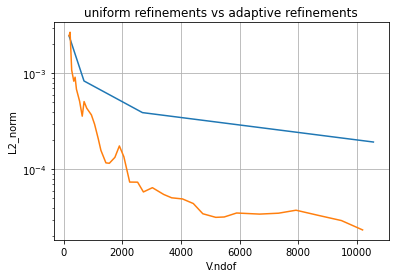

In [52]:
plt.figure()
plt.title("uniform refinements vs adaptive refinements")
plt.grid()
plt.semilogy(d_1,L2error_1)
plt.semilogy(d_2,L2error_2)
plt.xlabel("V.ndof")
plt.ylabel("L2_norm")
plt.savefig('uniform refinements vs adaptive refinements')

In [ ]:
plt.figure()
plt.title("totalruntime_per_iter_2000")
plt.plot(d,mk_2000,'-ob',label='res = 2000')
plt.xlabel("cores")
plt.ylabel("totalruntime_per_iter[ms]")
plt.grid()
plt.savefig('runtime_per_iter_2000')